In [23]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [24]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [25]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_AminoAcids.xlsx", encoding = 'unicode_escape')

In [26]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l1,label_l2,label_l3,label_l4,label_l5
0,Raw,Amino Acids,AA/ Single,AA/ Single,AA/ Single,AA/ Single,R50,Amino Acids,22000290,Taurine Powder 10lb Kosher,...,N001/Not assigned,0042/#,0042/Not assigned,3125.00,3039.13,Amino Acids,AA/ Single,AA/ Single,AA/ Single,AA/ Single
1,Raw,Amino Acids,AA/ Single,AA/ Single,AA/ Single,AA/ Single,R50,Amino Acids,22000290,Taurine Powder 10lb Kosher,...,N001/Not assigned,0042/#,0042/Not assigned,2158.50,2138.82,Amino Acids,AA/ Single,AA/ Single,AA/ Single,AA/ Single
2,Raw,Amino Acids,AA/ Single,AA/ Single,Not assigned,Not assigned,R50,Amino Acids,43947841,Amino Acid Glycine Powder 20kg,...,N001/Not assigned,0028/#,0028/Not assigned,99959.75,22253.30,Amino Acids,AA/ Single,AA/ Single,NaN,NaN
3,Raw,Amino Acids,AA/ Single,Not assigned,Not assigned,Not assigned,R50,Amino Acids,20340762,Amino Acid L-Arginine 10kg,...,N001/Not assigned,0028/#,0028/Not assigned,1039381.92,240511.41,Amino Acids,AA/ Single,NaN,NaN,NaN
4,Raw,Amino Acids,AA/ Single,Not assigned,Not assigned,Not assigned,R50,Amino Acids,20340763,Amino Acid L-Histidine,...,N001/Not assigned,0011/#,0011/Not assigned,109608.81,2522.86,Amino Acids,AA/ Single,NaN,NaN,NaN


In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])


# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [28]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc"]
y_column = ["label_l2_enc"]
seed = 10

In [29]:
df.label_l2.value_counts()

AA/ Single     356
AA/ Pre Mix     12
Name: label_l2, dtype: int64

In [30]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [31]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [33]:
print(y_train.label_l2_enc.value_counts())
print(y_valid.label_l2_enc.value_counts())
print(y_test.label_l2_enc.value_counts())


1    228
0      7
Name: label_l2_enc, dtype: int64
1    58
0     1
Name: label_l2_enc, dtype: int64
1    70
0     4
Name: label_l2_enc, dtype: int64


In [34]:
print("Train sample : %.0f "% (X_train.shape[0]))
print("Valid sample : %.0f "% (X_valid.shape[0]))
print("Test sample : %.0f "% (X_test.shape[0]))

Train sample : 235 
Valid sample : 59 
Test sample : 74 


In [35]:
from sklearn.feature_extraction.text import CountVectorizer

for selected_col in x_column:
    sentences_train = X_train[selected_col].values
    sentences_valid = X_valid[selected_col].values
    sentences_test = X_test[selected_col].values

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)

    X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
    X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
    X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [36]:
all_col = list(X_train.columns)

In [37]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')

In [38]:
from keras.utils import to_categorical

# LSTM Model 

In [39]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [40]:
model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                3450      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 22        
Total params: 3,472
Trainable params: 3,472
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [42]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9831
Testing Accuracy:  0.9730


In [43]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

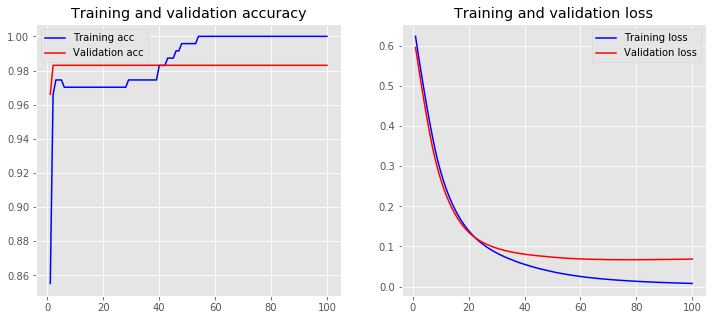

In [44]:
plot_history(history)

# Hyperparameter Tuning

In [57]:
def create_model(learning_rate=0.01, activation='relu'):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation=activation))
    model.add(layers.Dense(2, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer = opt,
                  loss = 'categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [58]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30,50],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [59]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [60]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [61]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/50
156/156 [==============================] - 0s 2ms/step - loss: 0.7151 - accuracy: 0.4167
Epoch 2/50
156/156 [==============================] - 0s 109us/step - loss: 0.3107 - accuracy: 0.9744
Epoch 3/50
156/156 [==============================] - 0s 134us/step - loss: 0.1251 - accuracy: 0.9744
Epoch 4/50
156/156 [==============================] - 0s 77us/step - loss: 0.0886 - accuracy: 0.9744
Epoch 5/50
156/156 [==============================] - 0s 102us/step - loss: 0.0765 - accuracy: 0.9744
Epoch 6/50
156/156 [==============================] - 0s 90us/step - loss: 0.0717 - accuracy: 0.9744
Epoch 7/50
156/156 [==============================] - 0s 147us/step - loss: 0.0668 - accuracy: 0.9808
Epoch 8/50
156/156 [==============================] - 0s 184us/step - loss: 0.0593 - accuracy: 0.9808
Epoch 9/50
156/156 [==============================] - 0s 128us/step - loss: 0.0516 - accuracy: 0.9808
Epoch 10/50
156/156 [==============================] - 0s 147us/st

157/157 [==============================] - 0s 70us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 30/50
157/157 [==============================] - 0s 89us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 31/50
157/157 [==============================] - 0s 95us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 32/50
157/157 [==============================] - 0s 38us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 33/50
157/157 [==============================] - 0s 89us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 34/50
157/157 [==============================] - 0s 108us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 35/50
157/157 [==============================] - 0s 108us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 36/50
157/157 [==============================] - 0s 95us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 37/50
157/157 [==============================] - 0s 70us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 38/50
157/157 [==============================] - 0s 63us/step - loss: 0.0025 - accurac

156/156 [==============================] - 0s 96us/step - loss: 0.0381 - accuracy: 0.9744
Epoch 8/20
156/156 [==============================] - 0s 102us/step - loss: 0.0298 - accuracy: 0.9744
Epoch 9/20
156/156 [==============================] - 0s 77us/step - loss: 0.0263 - accuracy: 0.9744
Epoch 10/20
156/156 [==============================] - 0s 89us/step - loss: 0.0244 - accuracy: 0.9744
Epoch 11/20
156/156 [==============================] - 0s 115us/step - loss: 0.0228 - accuracy: 0.9744
Epoch 12/20
156/156 [==============================] - 0s 90us/step - loss: 0.0218 - accuracy: 0.9744
Epoch 13/20
156/156 [==============================] - 0s 89us/step - loss: 0.0212 - accuracy: 0.9744
Epoch 14/20
156/156 [==============================] - 0s 108us/step - loss: 0.0204 - accuracy: 0.9744
Epoch 15/20
156/156 [==============================] - 0s 96us/step - loss: 0.0199 - accuracy: 0.9744
Epoch 16/20
156/156 [==============================] - 0s 83us/step - loss: 0.0196 - accuracy

157/157 [==============================] - 0s 82us/step - loss: 0.8440 - accuracy: 0.0382
Epoch 3/10
157/157 [==============================] - 0s 44us/step - loss: 0.8397 - accuracy: 0.0382
Epoch 4/10
157/157 [==============================] - 0s 108us/step - loss: 0.8355 - accuracy: 0.0382
Epoch 5/10
157/157 [==============================] - 0s 76us/step - loss: 0.8314 - accuracy: 0.0382
Epoch 6/10
157/157 [==============================] - 0s 89us/step - loss: 0.8276 - accuracy: 0.0382
Epoch 7/10
157/157 [==============================] - 0s 83us/step - loss: 0.8236 - accuracy: 0.0382
Epoch 8/10
157/157 [==============================] - 0s 82us/step - loss: 0.8199 - accuracy: 0.0382
Epoch 9/10
157/157 [==============================] - 0s 76us/step - loss: 0.8162 - accuracy: 0.0382
Epoch 10/10
157/157 [==============================] - 0s 57us/step
Epoch 1/20
156/156 [==============================] - 0s 3ms/step - loss: 0.4914 - accuracy: 0.8077
Epoch 2/20
156/156 [==============

156/156 [==============================] - 0s 90us/step - loss: 0.6198 - accuracy: 0.9167
Epoch 9/10
156/156 [==============================] - 0s 89us/step - loss: 0.6079 - accuracy: 0.9231
Epoch 10/10
156/156 [==============================] - 0s 90us/step
Epoch 1/10
157/157 [==============================] - 0s 2ms/step - loss: 0.6808 - accuracy: 0.5669
Epoch 2/10
157/157 [==============================] - 0s 121us/step - loss: 0.6702 - accuracy: 0.6688
Epoch 3/10
157/157 [==============================] - 0s 108us/step - loss: 0.6597 - accuracy: 0.6943
Epoch 4/10
157/157 [==============================] - 0s 108us/step - loss: 0.6497 - accuracy: 0.7707
Epoch 5/10
157/157 [==============================] - 0s 508us/step - loss: 0.6400 - accuracy: 0.8025
Epoch 6/10
157/157 [==============================] - 0s 254us/step - loss: 0.6302 - accuracy: 0.8280
Epoch 7/10
157/157 [==============================] - 0s 108us/step - loss: 0.6210 - accuracy: 0.8790
Epoch 8/10
157/157 [=========

157/157 [==============================] - 0s 121us/step - loss: 0.0203 - accuracy: 1.0000
Epoch 24/30
157/157 [==============================] - 0s 165us/step - loss: 0.0197 - accuracy: 1.0000
Epoch 25/30
157/157 [==============================] - 0s 241us/step - loss: 0.0194 - accuracy: 1.0000
Epoch 26/30
157/157 [==============================] - 0s 114us/step - loss: 0.0190 - accuracy: 1.0000
Epoch 27/30
157/157 [==============================] - 0s 178us/step - loss: 0.0186 - accuracy: 1.0000
Epoch 28/30
157/157 [==============================] - 0s 159us/step - loss: 0.0182 - accuracy: 1.0000
Epoch 29/30
157/157 [==============================] - 0s 140us/step - loss: 0.0177 - accuracy: 1.0000
Epoch 30/30
157/157 [==============================] - 0s 146us/step
Epoch 1/30
157/157 [==============================] - 1s 3ms/step - loss: 0.4687 - accuracy: 0.8790
Epoch 2/30
157/157 [==============================] - 0s 222us/step - loss: 0.1377 - accuracy: 0.9682
Epoch 3/30
157/157 [

156/156 [==============================] - 0s 173us/step - loss: 0.5717 - accuracy: 0.9744
Epoch 8/30
156/156 [==============================] - 0s 287us/step - loss: 0.5344 - accuracy: 0.9744
Epoch 9/30
156/156 [==============================] - 0s 166us/step - loss: 0.4932 - accuracy: 0.9744
Epoch 10/30
156/156 [==============================] - 0s 237us/step - loss: 0.4513 - accuracy: 0.9744
Epoch 11/30
156/156 [==============================] - 0s 185us/step - loss: 0.4095 - accuracy: 0.9744
Epoch 12/30
156/156 [==============================] - 0s 339us/step - loss: 0.3691 - accuracy: 0.9744
Epoch 13/30
156/156 [==============================] - 0s 255us/step - loss: 0.3311 - accuracy: 0.9744
Epoch 14/30
156/156 [==============================] - 0s 166us/step - loss: 0.2955 - accuracy: 0.9744
Epoch 15/30
156/156 [==============================] - 0s 153us/step - loss: 0.2646 - accuracy: 0.9744
Epoch 16/30
156/156 [==============================] - 0s 173us/step - loss: 0.2365 - a

157/157 [==============================] - 0s 197us/step - loss: 0.0703 - accuracy: 0.9745
Epoch 25/30
157/157 [==============================] - 0s 171us/step - loss: 0.0675 - accuracy: 0.9745
Epoch 26/30
157/157 [==============================] - 0s 172us/step - loss: 0.0651 - accuracy: 0.9745
Epoch 27/30
157/157 [==============================] - 0s 191us/step - loss: 0.0627 - accuracy: 0.9745
Epoch 28/30
157/157 [==============================] - 0s 146us/step - loss: 0.0605 - accuracy: 0.9745
Epoch 29/30
157/157 [==============================] - 0s 184us/step - loss: 0.0582 - accuracy: 0.9745
Epoch 30/30
157/157 [==============================] - 0s 153us/step
Epoch 1/30
156/156 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.8654
Epoch 2/30
156/156 [==============================] - 0s 115us/step - loss: 0.6170 - accuracy: 0.8718
Epoch 3/30
156/156 [==============================] - 0s 102us/step - loss: 0.6140 - accuracy: 0.8910
Epoch 4/30
156/156 [=

157/157 [==============================] - 0s 102us/step - loss: 0.7787 - accuracy: 0.0892
Epoch 11/30
157/157 [==============================] - 0s 115us/step - loss: 0.7756 - accuracy: 0.1083
Epoch 12/30
157/157 [==============================] - 0s 146us/step - loss: 0.7726 - accuracy: 0.1083
Epoch 13/30
157/157 [==============================] - 0s 140us/step - loss: 0.7696 - accuracy: 0.1274
Epoch 14/30
157/157 [==============================] - 0s 114us/step - loss: 0.7667 - accuracy: 0.1401
Epoch 15/30
157/157 [==============================] - 0s 134us/step - loss: 0.7637 - accuracy: 0.1465
Epoch 16/30
157/157 [==============================] - 0s 102us/step - loss: 0.7607 - accuracy: 0.1529
Epoch 17/30
157/157 [==============================] - 0s 159us/step - loss: 0.7578 - accuracy: 0.1720
Epoch 18/30
157/157 [==============================] - 0s 159us/step - loss: 0.7549 - accuracy: 0.1720
Epoch 19/30
157/157 [==============================] - 0s 127us/step - loss: 0.7519 -

157/157 [==============================] - 0s 254us/step - loss: 0.3928 - accuracy: 0.9682
Epoch 8/50
157/157 [==============================] - 0s 864us/step - loss: 0.3543 - accuracy: 0.9682
Epoch 9/50
157/157 [==============================] - 0s 870us/step - loss: 0.3186 - accuracy: 0.9682
Epoch 10/50
157/157 [==============================] - 0s 1ms/step - loss: 0.2874 - accuracy: 0.9682
Epoch 11/50
157/157 [==============================] - 0s 896us/step - loss: 0.2613 - accuracy: 0.9682
Epoch 12/50
157/157 [==============================] - 0s 470us/step - loss: 0.2381 - accuracy: 0.9682
Epoch 13/50
157/157 [==============================] - 0s 661us/step - loss: 0.2184 - accuracy: 0.9682
Epoch 14/50
157/157 [==============================] - 0s 680us/step - loss: 0.2019 - accuracy: 0.9682
Epoch 15/50
157/157 [==============================] - 0s 667us/step - loss: 0.1879 - accuracy: 0.9682
Epoch 16/50
157/157 [==============================] - 0s 127us/step - loss: 0.1758 - acc

157/157 [==============================] - 0s 108us/step - loss: 0.0623 - accuracy: 0.9809
Epoch 35/50
157/157 [==============================] - 0s 140us/step - loss: 0.0599 - accuracy: 0.9809
Epoch 36/50
157/157 [==============================] - 0s 146us/step - loss: 0.0579 - accuracy: 0.9809
Epoch 37/50
157/157 [==============================] - 0s 121us/step - loss: 0.0558 - accuracy: 0.9873
Epoch 38/50
157/157 [==============================] - 0s 114us/step - loss: 0.0540 - accuracy: 0.9873
Epoch 39/50
157/157 [==============================] - 0s 146us/step - loss: 0.0520 - accuracy: 0.9873
Epoch 40/50
157/157 [==============================] - 0s 120us/step - loss: 0.0502 - accuracy: 0.9873
Epoch 41/50
157/157 [==============================] - 0s 133us/step - loss: 0.0486 - accuracy: 0.9873
Epoch 42/50
157/157 [==============================] - 0s 133us/step - loss: 0.0469 - accuracy: 0.9873
Epoch 43/50
157/157 [==============================] - 0s 139us/step - loss: 0.0455 -

157/157 [==============================] - 0s 95us/step
Epoch 1/20
156/156 [==============================] - 1s 6ms/step - loss: 0.7599 - accuracy: 0.1923
Epoch 2/20
156/156 [==============================] - 0s 243us/step - loss: 0.7542 - accuracy: 0.2244
Epoch 3/20
156/156 [==============================] - 0s 83us/step - loss: 0.7485 - accuracy: 0.2500
Epoch 4/20
156/156 [==============================] - 0s 806us/step - loss: 0.7429 - accuracy: 0.2756
Epoch 5/20
156/156 [==============================] - 0s 70us/step - loss: 0.7373 - accuracy: 0.2885
Epoch 6/20
156/156 [==============================] - 0s 416us/step - loss: 0.7317 - accuracy: 0.2949
Epoch 7/20
156/156 [==============================] - 0s 102us/step - loss: 0.7262 - accuracy: 0.3141
Epoch 8/20
156/156 [==============================] - 0s 390us/step - loss: 0.7207 - accuracy: 0.3462
Epoch 9/20
156/156 [==============================] - 0s 448us/step - loss: 0.7152 - accuracy: 0.3846
Epoch 10/20
156/156 [=========

156/156 [==============================] - 0s 153us/step - loss: 0.6371 - accuracy: 0.7564
Epoch 17/50
156/156 [==============================] - 0s 121us/step - loss: 0.6323 - accuracy: 0.7756
Epoch 18/50
156/156 [==============================] - 0s 173us/step - loss: 0.6274 - accuracy: 0.7821
Epoch 19/50
156/156 [==============================] - 0s 90us/step - loss: 0.6225 - accuracy: 0.8077
Epoch 20/50
156/156 [==============================] - 0s 102us/step - loss: 0.6177 - accuracy: 0.8269
Epoch 21/50
156/156 [==============================] - 0s 173us/step - loss: 0.6129 - accuracy: 0.8462
Epoch 22/50
156/156 [==============================] - 0s 141us/step - loss: 0.6082 - accuracy: 0.8590
Epoch 23/50
156/156 [==============================] - 0s 109us/step - loss: 0.6035 - accuracy: 0.8590
Epoch 24/50
156/156 [==============================] - 0s 115us/step - loss: 0.5988 - accuracy: 0.8590
Epoch 25/50
156/156 [==============================] - 0s 121us/step - loss: 0.5942 - 

157/157 [==============================] - 0s 70us/step - loss: 0.6165 - accuracy: 0.9172
Epoch 45/50
157/157 [==============================] - 0s 83us/step - loss: 0.6147 - accuracy: 0.9172
Epoch 46/50
157/157 [==============================] - 0s 101us/step - loss: 0.6129 - accuracy: 0.9236
Epoch 47/50
157/157 [==============================] - 0s 101us/step - loss: 0.6111 - accuracy: 0.9236
Epoch 48/50
157/157 [==============================] - 0s 108us/step - loss: 0.6093 - accuracy: 0.9363
Epoch 49/50
157/157 [==============================] - 0s 95us/step - loss: 0.6075 - accuracy: 0.9363
Epoch 50/50
157/157 [==============================] - 0s 83us/step
Epoch 1/50
157/157 [==============================] - 1s 4ms/step - loss: 0.6539 - accuracy: 0.7898
Epoch 2/50
157/157 [==============================] - 0s 108us/step - loss: 0.6517 - accuracy: 0.8280
Epoch 3/50
157/157 [==============================] - 0s 171us/step - loss: 0.6494 - accuracy: 0.8599
Epoch 4/50
157/157 [=====

Epoch 1/20
157/157 [==============================] - 1s 3ms/step - loss: 0.5970 - accuracy: 0.9045
Epoch 2/20
157/157 [==============================] - 0s 127us/step - loss: 0.5286 - accuracy: 0.9618
Epoch 3/20
157/157 [==============================] - 0s 133us/step - loss: 0.4613 - accuracy: 0.9682
Epoch 4/20
157/157 [==============================] - 0s 127us/step - loss: 0.3913 - accuracy: 0.9682
Epoch 5/20
157/157 [==============================] - 0s 140us/step - loss: 0.3212 - accuracy: 0.9682
Epoch 6/20
157/157 [==============================] - 0s 133us/step - loss: 0.2564 - accuracy: 0.9682
Epoch 7/20
157/157 [==============================] - 0s 165us/step - loss: 0.2045 - accuracy: 0.9682
Epoch 8/20
157/157 [==============================] - 0s 197us/step - loss: 0.1657 - accuracy: 0.9682
Epoch 9/20
157/157 [==============================] - 0s 165us/step - loss: 0.1378 - accuracy: 0.9682
Epoch 10/20
157/157 [==============================] - 0s 184us/step - loss: 0.1174 

156/156 [==============================] - 0s 141us/step - loss: 0.4912 - accuracy: 0.9808
Epoch 6/10
156/156 [==============================] - 0s 179us/step - loss: 0.4772 - accuracy: 0.9744
Epoch 7/10
156/156 [==============================] - 0s 134us/step - loss: 0.4638 - accuracy: 0.9744
Epoch 8/10
156/156 [==============================] - 0s 147us/step - loss: 0.4507 - accuracy: 0.9744
Epoch 9/10
156/156 [==============================] - 0s 133us/step - loss: 0.4378 - accuracy: 0.9744
Epoch 10/10
156/156 [==============================] - 0s 90us/step
Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 0.7356 - accuracy: 0.2675
Epoch 2/10
157/157 [==============================] - 0s 127us/step - loss: 0.7168 - accuracy: 0.3439
Epoch 3/10
157/157 [==============================] - 0s 209us/step - loss: 0.6993 - accuracy: 0.4777
Epoch 4/10
157/157 [==============================] - 0s 254us/step - loss: 0.6822 - accuracy: 0.5732
Epoch 5/10
157/157 [=======

157/157 [==============================] - 0s 102us/step - loss: 0.4639 - accuracy: 0.9682
Epoch 21/30
157/157 [==============================] - 0s 121us/step - loss: 0.4575 - accuracy: 0.9682
Epoch 22/30
157/157 [==============================] - 0s 127us/step - loss: 0.4509 - accuracy: 0.9682
Epoch 23/30
157/157 [==============================] - 0s 343us/step - loss: 0.4444 - accuracy: 0.9682
Epoch 24/30
157/157 [==============================] - 0s 534us/step - loss: 0.4379 - accuracy: 0.9682
Epoch 25/30
157/157 [==============================] - 0s 241us/step - loss: 0.4316 - accuracy: 0.9682
Epoch 26/30
157/157 [==============================] - 0s 121us/step - loss: 0.4251 - accuracy: 0.9682
Epoch 27/30
157/157 [==============================] - 0s 146us/step - loss: 0.4187 - accuracy: 0.9682
Epoch 28/30
157/157 [==============================] - 0s 140us/step - loss: 0.4123 - accuracy: 0.9682
Epoch 29/30
157/157 [==============================] - 0s 127us/step - loss: 0.4061 -

156/156 [==============================] - 0s 703us/step - loss: 0.0138 - accuracy: 0.9808
Epoch 38/50
156/156 [==============================] - 0s 780us/step - loss: 0.0137 - accuracy: 1.0000
Epoch 39/50
156/156 [==============================] - 0s 690us/step - loss: 0.0136 - accuracy: 1.0000
Epoch 40/50
156/156 [==============================] - 0s 946us/step - loss: 0.0135 - accuracy: 1.0000
Epoch 41/50
156/156 [==============================] - 0s 761us/step - loss: 0.0134 - accuracy: 1.0000
Epoch 42/50
156/156 [==============================] - 0s 224us/step - loss: 0.0133 - accuracy: 1.0000
Epoch 43/50
156/156 [==============================] - 0s 352us/step - loss: 0.0132 - accuracy: 1.0000
Epoch 44/50
156/156 [==============================] - 0s 224us/step - loss: 0.0131 - accuracy: 1.0000
Epoch 45/50
156/156 [==============================] - 0s 339us/step - loss: 0.0130 - accuracy: 1.0000
Epoch 46/50
156/156 [==============================] - 0s 294us/step - loss: 0.0129 -

157/157 [==============================] - 0s 336us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 15/50
157/157 [==============================] - 0s 273us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 16/50
157/157 [==============================] - 0s 191us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 17/50
157/157 [==============================] - 0s 292us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 18/50
157/157 [==============================] - 0s 254us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 19/50
157/157 [==============================] - 0s 216us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 20/50
157/157 [==============================] - 0s 337us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 21/50
157/157 [==============================] - 0s 222us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 22/50
157/157 [==============================] - 0s 318us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 23/50
157/157 [==============================] - 0s 356us/step - loss: 9.4056e-

156/156 [==============================] - 0s 173us/step - loss: 0.6267 - accuracy: 0.9038
Epoch 9/20
156/156 [==============================] - 0s 186us/step - loss: 0.6225 - accuracy: 0.9167
Epoch 10/20
156/156 [==============================] - 0s 153us/step - loss: 0.6181 - accuracy: 0.9231
Epoch 11/20
156/156 [==============================] - 0s 179us/step - loss: 0.6139 - accuracy: 0.9359
Epoch 12/20
156/156 [==============================] - 0s 218us/step - loss: 0.6095 - accuracy: 0.9487
Epoch 13/20
156/156 [==============================] - 0s 153us/step - loss: 0.6052 - accuracy: 0.9487
Epoch 14/20
156/156 [==============================] - 0s 211us/step - loss: 0.6009 - accuracy: 0.9615
Epoch 15/20
156/156 [==============================] - 0s 236us/step - loss: 0.5965 - accuracy: 0.9615
Epoch 16/20
156/156 [==============================] - 0s 141us/step - loss: 0.5921 - accuracy: 0.9615
Epoch 17/20
156/156 [==============================] - 0s 198us/step - loss: 0.5878 - 

In [64]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.08828922125530687 and Best Params:  {'learning_rate': 0.01, 'epochs': 20, 'batch_size': 16, 'activation': 'tanh'}


Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 10)                3450      
_________________________________________________________________
dense_202 (Dense)            (None, 2)                 22        
Total params: 3,472
Trainable params: 3,472
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Valid Accuracy:  0.9831
Testing Accuracy:  0.9730


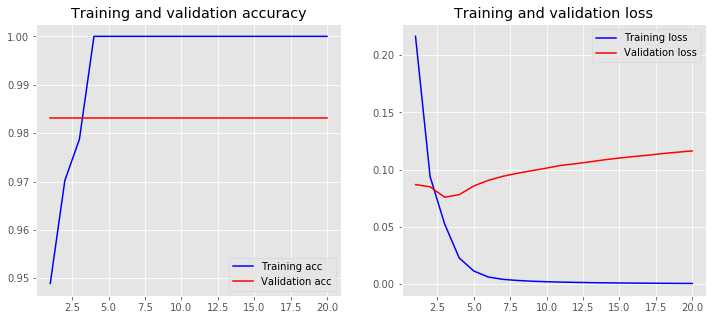

In [69]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='tanh'))
model.add(layers.Dense(2, activation='sigmoid'))

opt = Adam(learning_rate = 0.01)

model.compile(loss='categorical_crossentropy', 
               optimizer=opt, 
               metrics=['accuracy'])
model.summary()

history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=20,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=16)

loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

# Model Evaluation: Test Data

In [70]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9729729890823364


Confusion matrix, without normalization


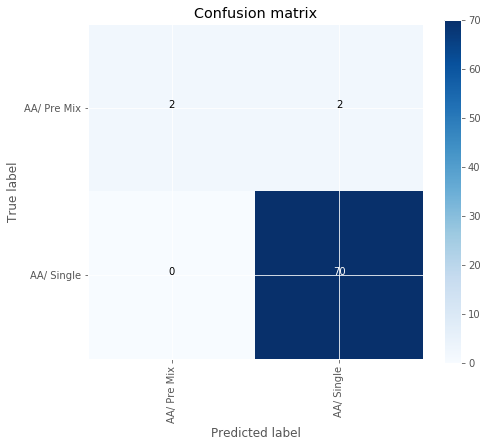

In [71]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [72]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.6542056074766356

In [73]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,AA/ Pre Mix,1.000000,0.5,0.666667,4
1,AA/ Single,0.972222,1.0,0.985915,70


In [75]:
tmp = pd.DataFrame(data = cnf_matrix,index = text_labels, columns = text_labels)
tmp["total"] = tmp.sum(axis=1)
accuracy= {"Category":[],"Accuracy":[]}
for i in range(tmp.shape[0]):
    accuracy["Category"].append(tmp.index[i])
    accuracy["Accuracy"].append(tmp.iloc[i,i]/tmp.loc[tmp.index[i],"total"])

print("Accuracy:")
print(pd.DataFrame(accuracy))

Accuracy:
      Category  Accuracy
0  AA/ Pre Mix       0.5
1   AA/ Single       1.0


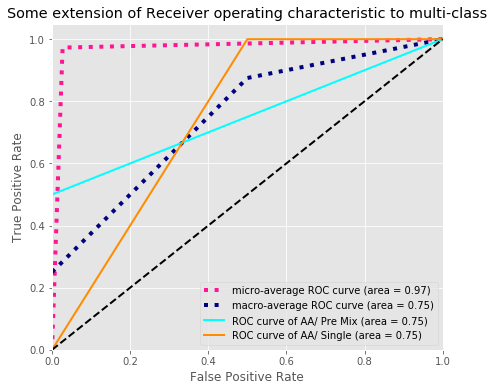

In [80]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [81]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.96


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.96')

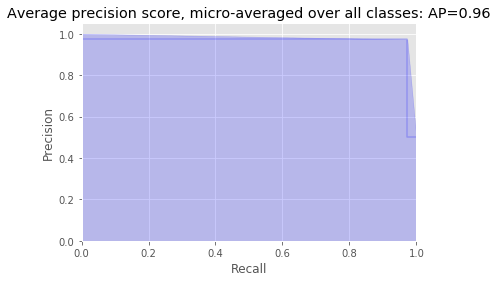

In [82]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

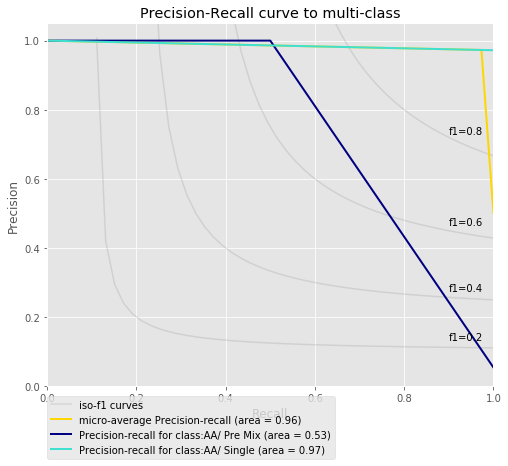

In [83]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()